In [ ]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.5 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import re

C1true = 1.0
C2true = 0.01

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



# Load the training data from matlab

In [ ]:
# Load the training data

def load_training_data(num):
    #print("hi")
    data = loadmat("/content/drive/MyDrive/Colab Notebooks/CFD_Unet/cylinder_nektar_wake.mat")
    #print(data)
    U_star = data["U_star"] # N x 2 x T
    P_star = data["p_star"] # N x T
    t_star = data["t"] # T
    X_star = data["X_star"] # N x 2

    N = X_star.shape[0]
    T = t_star.shape[0]

    XX = np.tile(X_star[:,0:1], [1, T]) # N x T
    YY = np.tile(X_star[:,1:2], [1, T]) # N x T
    TT = np.tile(t_star, [1, N]).T
    UU = U_star[:,0,:] # N x T
    VV = U_star[:,1,:] # N x T
    PP = P_star

    x = XX.flatten()[:,None] # NT x 1
    y = YY.flatten()[:,None] # NT x 1
    t = TT.flatten()[:,None] # NT x 1
    u = UU.flatten()[:,None] # NT x 1
    v = VV.flatten()[:,None] # NT x 1
    p = PP.flatten()[:,None] # NT x 1

    data1 = np.concatenate([x,y,t,u,v,p], 1)
    data2 = data1[:,:][data1[:,2] <= 7 ]
    data3 = data2[:,:][data2[:,0] >= 1 ]
    data4 = data3[:,:][data3[:,0] <= 8 ]
    data5 = data4[:,:][data4[:,1] >= -2 ]
    data6 = data5[:,:][data5[:,1] <= 2 ]
    data_domain = data6

    idx = np.random.choice(data_domain.shape[0], num, replace=False)
    x_train = data_domain[idx,0:1]
    y_train = data_domain[idx,1:2]
    t_train = data_domain[idx,2:3]
    u_train = data_domain[idx,3:4]
    v_train = data_domain[idx,4:5]
    p_train = data_domain[idx,5:6]


    return [x_train, y_train, t_train, u_train, v_train, p_train]

In [ ]:
[ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=7000)
print("ob_y.shape", ob_y.shape)
print("ob_t.shape", ob_t.shape)
ob_xyt = np.hstack((ob_x, ob_y, ob_t))
print("ob_xyt.shape", ob_xyt.shape)

ob_y.shape (7000, 1)
ob_t.shape (7000, 1)
ob_xyt.shape (7000, 3)


# Difine Neural Network

In [ ]:
C1 = dde.Variable(0.0)
C2 = dde.Variable(0.0)

In [ ]:
def Navier_Stokes_Equation(x,y):
    u = y[:, 0:1]
    v = y[:, 1:2]
    p = y[:, 2:3]
    # du/dx, du/dy, du/dt
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    du_t = dde.grad.jacobian(y, x, i=0, j=2)
    # dv/dx dv/dy dv/dt
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dv_t = dde.grad.jacobian(y, x, i=1, j=2)
    #dp/dx dp/dy
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)
    # d2u/dx2 d2u/dy2
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)

    dv_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)


    continuity = du_x + du_y
    x_momentum = du_t + C1 * (u * du_x + v * du_y) + dp_x - C2 * (du_xx + du_yy)
    y_momentum = dv_t + C1 * (u * dv_x + v * dv_y) + dp_y - C2 * (dv_xx + dv_yy)
    return [continuity, x_momentum, y_momentum]

In [ ]:
# definet the DNN
layer_size = [3] + [50] * 6 + [3]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

# define the BC and IC

In [ ]:
Lx_min, Lx_max = 1.0, 8.0
Ly_min, Ly_max = -2.0, 2.0
space_domain = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])

time_domain = dde.geometry.TimeDomain(0, 7)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

In [ ]:
observe_u = dde.icbc.PointSetBC(ob_xyt, ob_u, component=0)
observe_v = dde.icbc.PointSetBC(ob_xyt, ob_v, component=1)

observe_p = dde.icbc.PointSetBC(ob_xyt, ob_p, component=2)

# Loss Function

In [ ]:
# training datasets used to caluculate the loss
data = dde.data.TimePDE(geomtime, Navier_Stokes_Equation,
                        [observe_u, observe_v, observe_p],
                        num_domain = 700,
                        num_boundary = 200,
                        num_initial = 100,
                        anchors = ob_xyt)

# Optimizer

In [ ]:
'''model = dde.Model(data, net)

result_file_C1_C2 = "variables_main_C1_C2.dat"
variable = dde.callbacks.VariableValue([C1,C2], period = 100, filename = result_file_C1_C2)

model.compile("adam", lr = 1e-3, external_trainable_variables=[C1, C2])
loss_history, train_state = model.train(iterations=10000, callbacks=[variable], display_every=1000, disregard_previous_best=True)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

model.compile("adam", lr = 1e-4, external_trainable_variables=[C1, C2])
loss_history, train_state = model.train(iterations=10000, callbacks=[variable], display_every=1000, disregard_previous_best=True)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

f = model.predict(ob_xyt, operator = Navier_Stokes_Equation)
print("Mean residula:", np.mean(np.absolute(f)))
'''

'model = dde.Model(data, net)\n\nresult_file_C1_C2 = "variables_main_C1_C2.dat"\nvariable = dde.callbacks.VariableValue([C1,C2], period = 100, filename = result_file_C1_C2)\n\nmodel.compile("adam", lr = 1e-3, external_trainable_variables=[C1, C2])\nloss_history, train_state = model.train(iterations=10000, callbacks=[variable], display_every=1000, disregard_previous_best=True)\ndde.saveplot(loss_history, train_state, issave=True, isplot=True)\n\nmodel.compile("adam", lr = 1e-4, external_trainable_variables=[C1, C2])\nloss_history, train_state = model.train(iterations=10000, callbacks=[variable], display_every=1000, disregard_previous_best=True)\ndde.saveplot(loss_history, train_state, issave=True, isplot=True)\n\nf = model.predict(ob_xyt, operator = Navier_Stokes_Equation)\nprint("Mean residula:", np.mean(np.absolute(f)))\n'

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Compiling model...
Building feed-forward neural network...
'build' took 0.281700 s

'compile' took 4.736984 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.32e-02, 2.84e-02, 1.25e-02, 9.85e-01, 1.21e-01, 9.54e-02]    [2.32e-02, 2.84e-02, 1.25e-02, 9.85e-01, 1.21e-01, 9.54e-02]    []  
1000      [1.05e-02, 1.62e-03, 1.49e-03, 3.95e-02, 6.27e-03, 2.61e-03]    [1.05e-02, 1.62e-03, 1.49e-03, 3.95e-02, 6.27e-03, 2.61e-03]    []  
2000      [1.08e-02, 1.57e-03, 1.15e-03, 3.66e-02, 2.23e-03, 2.22e-03]    [1.08e-02, 1.57e-03, 1.15e-03, 3.66e-02, 2.23e-03, 2.22e-03]    []  
3000      [1.09e-02, 1.70e-03, 1.04e-03, 3.57e-02, 1.52e-03, 2.10e-03]    [1.09e-02, 1.70e-03, 1.04e-03, 3.57e-02, 1.52e-03, 2.10e-03]    []  
4000      [1.10e-02, 1.60e-03, 8.55e-04, 3.49e-02, 1.12e-03, 2.06e-03]

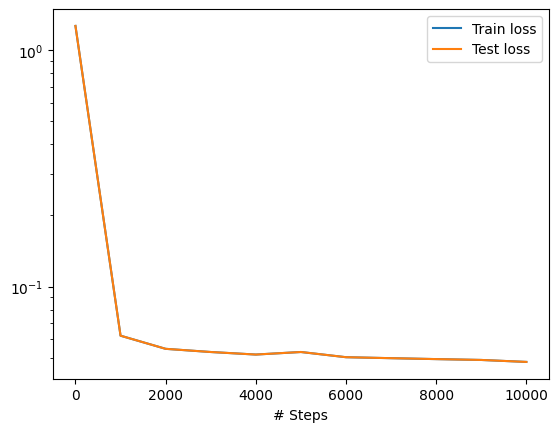

Compiling model...
'compile' took 1.403448 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
10000     [1.12e-02, 1.55e-03, 6.66e-04, 3.22e-02, 6.34e-04, 1.81e-03]    [1.12e-02, 1.55e-03, 6.66e-04, 3.22e-02, 6.34e-04, 1.81e-03]    []  
11000     [1.10e-02, 1.59e-03, 6.82e-04, 3.15e-02, 6.24e-04, 1.79e-03]    [1.10e-02, 1.59e-03, 6.82e-04, 3.15e-02, 6.24e-04, 1.79e-03]    []  
12000     [1.08e-02, 1.69e-03, 6.68e-04, 3.02e-02, 6.37e-04, 1.73e-03]    [1.08e-02, 1.69e-03, 6.68e-04, 3.02e-02, 6.37e-04, 1.73e-03]    []  
13000     [1.04e-02, 1.76e-03, 6.77e-04, 2.88e-02, 6.32e-04, 1.71e-03]    [1.04e-02, 1.76e-03, 6.77e-04, 2.88e-02, 6.32e-04, 1.71e-03]    []  


In [ ]:
import deepxde as dde
import numpy as np
import tensorflow as tf

# GPUが利用可能か確認
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Using CPU.")

# モデル構築
model = dde.Model(data, net)

# 可変パラメータのログ
result_file_C1_C2 = "variables_main_C1_C2.dat"
variable = dde.callbacks.VariableValue([C1, C2], period=100, filename=result_file_C1_C2)

# 第1フェーズ学習
model.compile("adam", lr=1e-3, external_trainable_variables=[C1, C2])
loss_history, train_state = model.train(
    iterations=10000,
    callbacks=[variable],
    display_every=1000,
    disregard_previous_best=True
)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

# 第2フェーズ学習（学習率変更）
model.compile("adam", lr=1e-4, external_trainable_variables=[C1, C2])
loss_history, train_state = model.train(
    iterations=10000,
    callbacks=[variable],
    display_every=1000,
    disregard_previous_best=True
)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

# 予測 + 残差の評価
f = model.predict(ob_xyt, operator=Navier_Stokes_Equation)
print("Mean residual:", np.mean(np.abs(f)))
